##### Fake job advertisements are one of the popular scams nowadays. People send their data and end up with a scam and waste their money. Our objective is to detect such fraudulent job ads using Natural Language Processing and Supervised Machine Learning.

In [140]:
# importing necessary libraries
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [8]:
df_main = pd.read_csv('fake_job_postings.csv')
df_main.shape

(17880, 18)

In [6]:
df_main.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [7]:
df_main.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

There are significant number of null values in many of the features.

In [9]:
df_main.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

In [10]:
df_main.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [13]:
df_main.apply(lambda i: len(i.unique()))

job_id                 17880
title                  11231
location                3106
department              1338
salary_range             875
company_profile         1710
description            14802
requirements           11969
benefits                6206
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            6
required_experience        8
required_education        14
industry                 132
function                  38
fraudulent                 2
dtype: int64

We have 17,880 unique job listings from 3106 different locations. The unique entries for each of the features can be seen above. There are 4 categorical variables including fraudulent.

In [22]:
df_main[['telecommuting','has_company_logo','has_questions','employment_type','required_experience','fraudulent']]

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent
0,0,1,0,Other,Internship,0
1,0,1,0,Full-time,Not Applicable,0
2,0,1,0,NaN,NaN,0
3,0,1,0,Full-time,Mid-Senior level,0
4,0,1,1,Full-time,Mid-Senior level,0
...,...,...,...,...,...,...
17875,0,1,1,Full-time,Mid-Senior level,0
17876,0,1,1,Full-time,Mid-Senior level,0
17877,0,0,0,Full-time,NaN,0
17878,0,0,1,Contract,Not Applicable,0


In [28]:
cat = ['telecommuting','has_company_logo','has_questions','employment_type','required_experience','fraudulent']
df_main[cat].apply(lambda i: print(i.unique()))

[0 1]
[1 0]
[0 1]
['Other' 'Full-time' nan 'Part-time' 'Contract' 'Temporary']
['Internship' 'Not Applicable' nan 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']
[0 1]


telecommuting          None
has_company_logo       None
has_questions          None
employment_type        None
required_experience    None
fraudulent             None
dtype: object

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

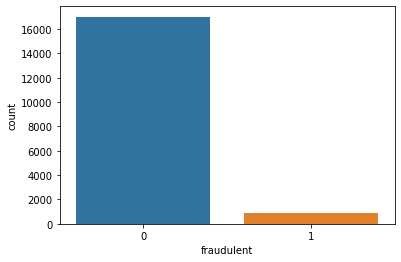

In [37]:
# Class imbalance - very small number of postings are actually fraudulent from the data given
sns.countplot(df_main['fraudulent'])

We actually couldn't retrieve any information from "Job Id, Telecommuting, Has Company Logo, Has Questions, Employment Type, Salary Range" features based on which we can detect a job posting as fake.

In [45]:
df = df_main.drop(['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type'],axis=1)
df = df.fillna(" ") #replacing nulls with spaces since the features are text

In [46]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [66]:
df['country'] = df['location'].str.split(',',expand=True)[0]
len(set(df['country']))

91

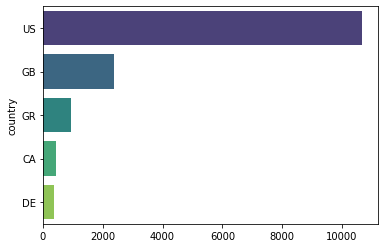

In [96]:
top_country = df.groupby(by = 'country')['fraudulent'].count().sort_values(ascending=False)[:5]
sns.barplot(x= top_country.values,y= top_country.index, palette = 'viridis')
plt.show()

US has more number of Job postings.

In [102]:
df.head(1)

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US


In [117]:
df['textual'] = df['title'] + ' ' + df['location'] + ' ' +df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['required_experience'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function']


In [118]:
df.head(1)

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country,textual
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US,"Marketing Intern US, NY, New York We're Food52..."


In [123]:
stop = stopwords.words('english')


In [169]:
# 866 fraudulent jobs
# getting text information about the jobs removing stop words
text_fraud_df = df[df['fraudulent']==1]['textual'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
text_not_fraud_df = df[df['fraudulent']==0]['textual'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# data cleaning
def clean_message(message):

    msg_clean = re.sub(r'(https?://[^\s]+)','',message) #links
    msg_clean = re.sub(r'[^\w\s]','',msg_clean) #punctuation
    
    lower_case = msg_clean.lower()
    tokens = word_tokenize(lower_case)
    cleaned = [i for i in tokens if not i in stopwords.words('english')] #removed stop words
    
    messages_cleaned = [PorterStemmer().stem(i) for i in cleaned] #stemming
    
    return messages_cleaned

In [161]:
text_fraud = text_fraud_df.apply(clean_message)
text_not_fraud = text_not_fraud_df.apply(clean_message)

In [167]:
text_fraud.apply(' '.join)

98       ice technician us stocton ca staf amp recruit ...
144      forward cap group rais fund purchas home south...
173      technician instrument control us edison intern...
180      sale execut pk sd karachi sale execut sale exe...
215      ice technician mt poso us ca bakersfield ca mt...
                               ...                        
17827    student posit parttim fulltim us ca lo angel s...
17828    sale associ au nsw sydney learn earn execut le...
17829    android develop pl mz warsaw infullmobil sp z ...
17830    payrol clerk us ny new york job descriptionw s...
17831    furnitur mover us il chicago anthoni warren ma...
Name: textual, Length: 866, dtype: object

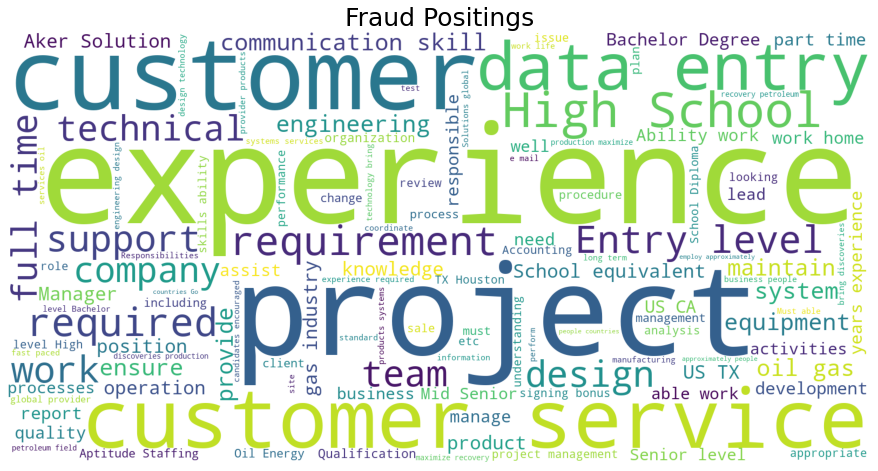

In [170]:
wordcloud = WordCloud(width = 1600, height = 800, 
            background_color ='white', 
            min_font_size = 10).generate(''.join(text_fraud_df) )

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Fraud Positings',fontsize=25)
plt.show() 

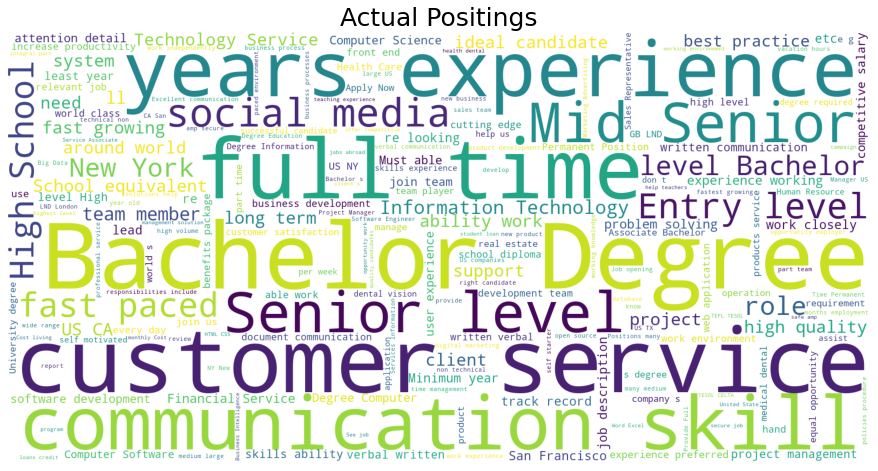

In [171]:
wordcloud = WordCloud(width = 1600, height = 800, 
            background_color ='white', 
            min_font_size = 10).generate(''.join(text_not_fraud_df) )

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Actual Positings',fontsize=25)
plt.show() 

We cannot really comment about the postings being fraud just looking at the word clouds. Customer centric positings seem fake where as postings that require experience seem original, as can be inferred from the word cloud.

#### N-gram Analysis

In [182]:
word_vectorizer = CountVectorizer(ngram_range=(2,4), analyzer='word') # intersted to look at grams upto 4
sparse_matrix = word_vectorizer.fit_transform(text_fraud.apply(' '.join))
frequencies = sum(sparse_matrix).toarray()[0]

top_ngrams_fraud = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by='frequency',ascending = False)

In [183]:
word_vectorizer = CountVectorizer(ngram_range=(2,4), analyzer='word') # intersted to look at grams upto 4
sparse_matrix = word_vectorizer.fit_transform(text_not_fraud.apply(' '.join))
frequencies = sum(sparse_matrix).toarray()[0]

top_ngrams_not_fraud = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by='frequency',ascending = False)

In [192]:
top_ngrams_not_fraud.head(50)

,frequency
custom servic,6801
bachelor degre,5963
year experi,4230
inform technolog,3940
midsenior level,3698
commun skill,3484
entri level,2967
social media,2960
level bachelor,2626
level bachelor degre,2626


In [211]:
top_ngrams_not_fraud['frequency'].index

Index(['custom servic', 'bachelor degre', 'year experi', 'inform technolog',
       'midsenior level', 'commun skill', 'entri level', 'social media',
       'level bachelor', 'level bachelor degre',
       ...
       'happi ideal candidateget', 'happi ideal candidateget excit',
       'happi increas', 'happi increas sale', 'happi increas sale involv',
       'happi indulg', 'happi indulg stereotyp',
       'happi indulg stereotyp develop', 'happi inform',
       'ﬂexibl take account serious'],
      dtype='object', length=4424500)

In [210]:
y

Index(['custom servic', 'bachelor degre', 'year experi', 'inform technolog',
       'midsenior level', 'commun skill', 'entri level', 'social media',
       'level bachelor', 'level bachelor degre'],
      dtype='object')

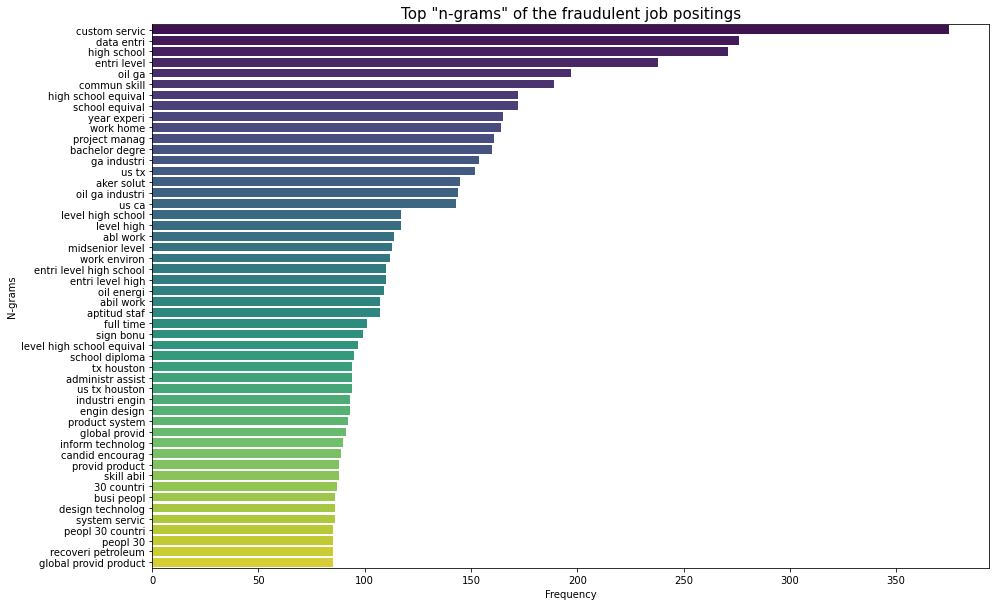

In [226]:
x = top_ngrams_fraud['frequency'].values[:50]
y = top_ngrams_fraud.index[:50]

plt.figure(figsize=(15,10))
sns.barplot(x= x,y= y, palette = 'viridis')
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top "n-grams" of the fraudulent job positings',fontsize=15)
plt.show()


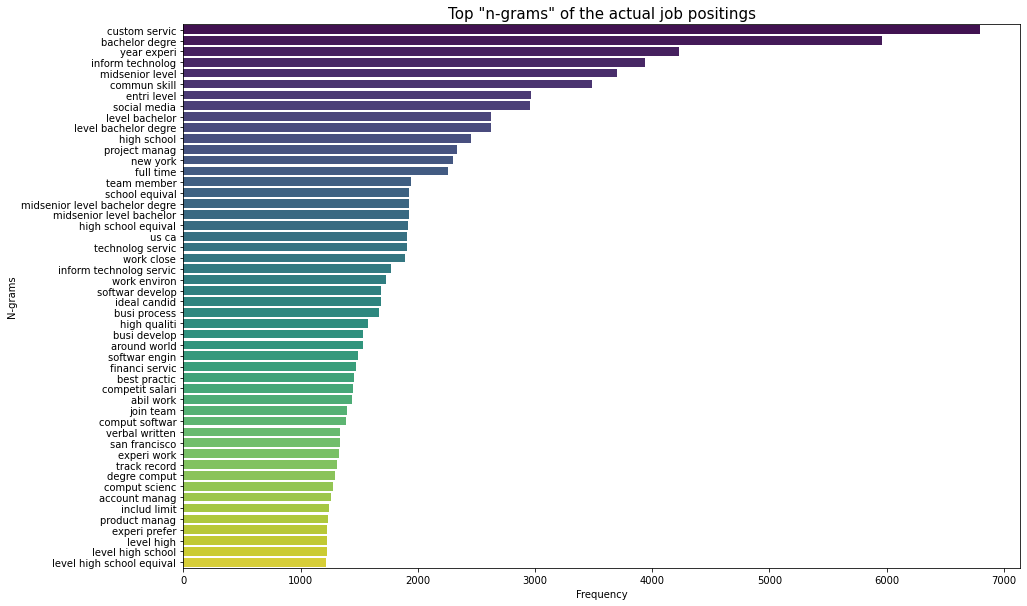

In [225]:
x = top_ngrams_not_fraud['frequency'].values[:50]
y = top_ngrams_not_fraud.index[:50]

plt.figure(figsize=(15,10))
sns.barplot(x= x,y= y, palette = 'viridis')
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top "n-grams" of the actual job positings',fontsize=15)
plt.show()


##### already tokenized and cleaned data frames
* text_fraud
* text_not_fraud

##### combined text data frame
* text_fraud_df
* text_not_fraud_df

### Modeling

In [296]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB

In [252]:
Y = df['fraudulent'] #target - fraudulent information

#df['textual'].apply(clean_message)

X = pd.concat([text_fraud,text_not_fraud],ignore_index = False).apply(' '.join).sort_index() #textual information - cleaned


In [275]:
# stratifying to split the data equally
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=78, stratify=Y)

In [276]:
# Appling Count Vectorizer
count_vectorizer = CountVectorizer()
train_X_vec = count_vectorizer.fit_transform(X_train)
test_X_vec = count_vectorizer.transform(X_test)

In [280]:
data_dict = {
    'train': (train_X_vec, y_train),
    'test': (test_X_vec, y_test)
}

In [290]:
def predictions(model, X, y):
    return evaluation_metrics(y,model.predict(X))


def evaluation_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    return {
        'accuracy': accuracy,
        'error': 1 - accuracy,
        
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

def compare_models(*models):
    metrics = []
    for model in models:
        model.fit(train_X_vec, y_train)
        for data_type, (X, y) in data_dict.items():
            
            metrics.append(
                {'data_type': data_type, 'model': model.__class__.__name__,
                 **predictions(model, X, y)})
    return pd.DataFrame(metrics).sort_values('model').set_index(['model','data_type'])


In [298]:
compare_models(LogisticRegression(), RandomForestClassifier(), SVC(), KNeighborsClassifier())

accuracy     error  precision    recall  \
model                  data_type                                            
KNeighborsClassifier   train      0.943722  0.056278   0.456454  0.847042   
                       test       0.919183  0.080817   0.352041  0.797688   
LogisticRegression     train      0.999790  0.000210   1.000000  0.995671   
                       test       0.982662  0.017338   0.888112  0.734104   
RandomForestClassifier train      0.999930  0.000070   1.000000  0.998557   
                       test       0.981544  0.018456   1.000000  0.618497   
SVC                    train      0.983361  0.016639   1.000000  0.656566   
                       test       0.973434  0.026566   1.000000  0.450867   

                                  f1_score  
model                  data_type            
KNeighborsClassifier   train      0.593229  
                       test       0.488496  
LogisticRegression     train      0.997831  
                       test       0.803797  
RandomForestClassifier train      0.999278  
                       test       0.764286  
SVC                    train      0.792683  
                       test       0.621514

Class imbalance - even though through stratifying we split the data such that they are equal, we still have the problem of class imbalance. 

In [309]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling  import RandomOverSampler
from sklearn.feature_extraction.text import TfidfTransformer

In [311]:
data_dict = {
    'train': (X_train, y_train),
    'test': (X_test, y_test)
}

In [320]:
def compare_models(*models):
    metrics = []
    for model in models:
        pipe = Pipeline([('vect',  CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=9)),
                     ('model',   model)])
        pipe.fit(X_train, y_train)
        for data_type, (X, y) in data_dict.items():
            
            metrics.append(
                {'data_type': data_type, 'model': model.__class__.__name__,
                 **predictions(pipe, X, y)})
    return pd.DataFrame(metrics).sort_values('model').set_index(['model','data_type'])


In [321]:
compare_models(LogisticRegression(), RandomForestClassifier(), SVC(), KNeighborsClassifier())

accuracy     error  precision    recall  \
model                  data_type                                            
KNeighborsClassifier   train      0.982732  0.017268   0.737234  1.000000   
                       test       0.975391  0.024609   0.685590  0.907514   
LogisticRegression     train      0.992240  0.007760   0.861940  1.000000   
                       test       0.980984  0.019016   0.772021  0.861272   
RandomForestClassifier train      1.000000  0.000000   1.000000  1.000000   
                       test       0.981264  0.018736   1.000000  0.612717   
SVC                    train      0.999720  0.000280   0.994261  1.000000   
                       test       0.984899  0.015101   0.983740  0.699422   

                                  f1_score  
model                  data_type            
KNeighborsClassifier   train      0.848745  
                       test       0.781095  
LogisticRegression     train      0.925852  
                       test       0.814208  
RandomForestClassifier train      1.000000  
                       test       0.759857  
SVC                    train      0.997122  
                       test       0.817568

In [310]:
# train_X_vec = count_vectorizer.fit_transform(X_train)
# test_X_vec = count_vectorizer.transform(X_test)

pipe = Pipeline([('vect',    CountVectorizer()),
#                      ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   LogisticRegression())])

model = pipe.fit(X_train, y_train)
pred  = model.predict(X_test)

### Our base model Logistic regression seems to work well for this dataset when compared to rest of the models.

### There are a couple of limitations to out project -  we have not fine tuned our hyperparameters. Anyways, we are not hoping for much improvement since logistic turned out to be the better one

#### GloVe

#### Bert